In [1]:
import os
from pathlib import Path
import math
import json
import numpy as np
import torch
import matplotlib.pyplot as plt
from models import get_model
from toolbox.losses import get_criterion
from toolbox import metrics
from loaders.data_generator import Generator
from loaders.siamese_loaders import siamese_loader
from toolbox.metrics import all_losses_acc, accuracy_linear_assignment

In [2]:
def get_device_config(model_path):
    config_file = os.path.join(model_path,'config.json')
    with open(config_file) as json_file:
        config_model = json.load(json_file)
    use_cuda = not config_model['cpu'] and torch.cuda.is_available()
    device = 'cuda' if use_cuda else 'cpu'
    return config_model, device

def load_model(model_path, config, device):
    model = get_model(config['arch'])
    model.to(device)
    model_file = os.path.join(model_path,'model_best.pth.tar')
    checkpoint = torch.load(model_file)
    model.load_state_dict(checkpoint['state_dict'])
    return model

def creat_args(config, num_ex = 1000):
    args = config['data']
    args['num_examples_test'] = num_ex
    n_vertices = args['n_vertices']
    edge_density = args['edge_density']
    deg = (n_vertices-1)*edge_density
    print(f'graphs with {n_vertices} vertices and average degree {deg}')
    return args, deg

def acc_2_error(mean_acc, q_acc):
    error = q_acc-mean_acc[:,np.newaxis]
    error[:,0] = -error[:,0]
    return error

def compute_all(list_noise,args,model,bs=50):
    num_batches = math.ceil(args['num_examples_test']/bs)
    all_losses = np.zeros((len(list_noise),num_batches))
    all_acc = np.zeros((len(list_noise),args['num_examples_test']))
    for i,noise in enumerate(list_noise):
        args['noise'] = noise
        gene_test = Generator('test', args)
        gene_test.load_dataset()
        test_loader = siamese_loader(gene_test, bs, gene_test.constant_n_vertices)
        all_losses[i,:], all_acc[i,:] = all_losses_acc(test_loader,model,criterion,device,eval_score=accuracy_linear_assignment)
    return all_losses, all_acc

def compute_quant(all_acc,quant_low=0.1,quant_up=0.9):
    mean_acc = np.mean(all_acc,1)
    num = len(mean_acc)
    q_acc = np.zeros((num,2))
    for i in range(num):
        q_acc[i,:] = np.quantile(all_acc[i,:],[quant_up, quant_low])
    return mean_acc, q_acc

# Downloading the pretrained model

The cell below should only be run once, it creates a folder `downloads/` and then downloads in this folder the pretrained model and the configuration file.

In [3]:
import requests
config_url = 'https://github.com/mlelarge/graph_neural_net/releases/download/QAP/config.json'
model_url = 'https://github.com/mlelarge/graph_neural_net/releases/download/QAP/model_best.pth.tar'
%mkdir downloads
cwd = os.getcwd()

r = requests.get(config_url)
with open(cwd+'/downloads/config.json', 'wb') as f:
    f.write(r.content)

r = requests.get(model_url)
with open(cwd+'/downloads/model_best.pth.tar', 'wb') as f:
    f.write(r.content)

In [4]:
model_path = cwd+'/downloads/'
config_model, device = get_device_config(model_path)
model = load_model(model_path,config_model,device)
criterion = get_criterion(device, config_model['train']['loss_reduction'])

Fetching model Siamese_Model - Simple_Node_Embedding 


In [5]:
args,deg  = creat_args(config_model)

graphs with 50 vertices and average degree 9.8


In [6]:
num = 23
list_noise = np.linspace(0, 0.22, num=num)

# Inference

The cell below will create dataset of graphs with various level of noise if they do not exist, otherwise it will only read them.

In [7]:
all_l, all_a = compute_all(list_noise,args,model)

Reading dataset at dataset/QAP_Regular_ErdosRenyi_1000_50_1.0_0.0_0.2/test.pkl
Reading dataset at dataset/QAP_Regular_ErdosRenyi_1000_50_1.0_0.01_0.2/test.pkl
Reading dataset at dataset/QAP_Regular_ErdosRenyi_1000_50_1.0_0.02_0.2/test.pkl
Reading dataset at dataset/QAP_Regular_ErdosRenyi_1000_50_1.0_0.03_0.2/test.pkl
Reading dataset at dataset/QAP_Regular_ErdosRenyi_1000_50_1.0_0.04_0.2/test.pkl
Reading dataset at dataset/QAP_Regular_ErdosRenyi_1000_50_1.0_0.05_0.2/test.pkl
Reading dataset at dataset/QAP_Regular_ErdosRenyi_1000_50_1.0_0.06_0.2/test.pkl
Reading dataset at dataset/QAP_Regular_ErdosRenyi_1000_50_1.0_0.07_0.2/test.pkl
Reading dataset at dataset/QAP_Regular_ErdosRenyi_1000_50_1.0_0.08_0.2/test.pkl
Reading dataset at dataset/QAP_Regular_ErdosRenyi_1000_50_1.0_0.09_0.2/test.pkl
Reading dataset at dataset/QAP_Regular_ErdosRenyi_1000_50_1.0_0.1_0.2/test.pkl
Reading dataset at dataset/QAP_Regular_ErdosRenyi_1000_50_1.0_0.11_0.2/test.pkl
Reading dataset at dataset/QAP_Regular_Erd

# Results

The FGNN has been trained with regular graphs with $50$ vertices, average degree $10$ and noise level $0.15$. The accuracy below is the fraction of matched vertices between two noisy versions of a given graph at various level of noise.

In [8]:
quant_low=0.1
quant_up=0.9
mc_50, q50 = compute_quant(all_a,quant_low=quant_low,quant_up=quant_up)

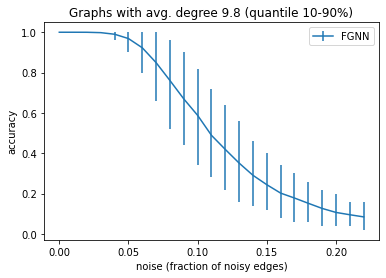

In [9]:
error_50 = acc_2_error(mc_50,q50)

plt.errorbar(list_noise,mc_50,yerr=error_50.T,label='FGNN');
plt.xlabel('noise (fraction of noisy edges)')
plt.ylabel('accuracy')
plt.title(f'Graphs with avg. degree {deg} (quantile {int(100*quant_low)}-{int(100*quant_up)}%)')
plt.legend()
plt.show()